In [1]:
# importing necessary libraries
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs
import sklearn

# Секция работы с API "Coctails"

Здесь я использую указаннное апи, чтобы получить данные о нескольких сотнях коктейлей и их составе

> https://www.thecocktaildb.com/api.php


Задействованные методы:


*   Работа с API
*   Pandas
*   Regex
*   Numpy
*   Matplotlib
*   Networkx
*   Библиотека, не обсуждавшаяся в ходе курса -- Translate Python

Все комментарии в коде сделаны по английски, чтобы сделать код универсальным для копирования в другие проекты



In [2]:
# measures in JSON is in form '1 1/2 oz ', need to convert it to float to calculate coctail's alco level
import re

def convert_measure(measure):
    # Define a regular expression pattern to match the measure
    # for fraction part
    pattern1 = r'\d+\/\d+'
    # for whole part
    pattern2 = r'^\d+\s'

    # Use re.match to extract the parts of the measure
    match1 = re.findall(pattern1, measure)
    if match1:
        numerator, denominator = match1[0].split('/')
        fraction = float(numerator) / float(denominator)
    else:
        fraction=0

    match2 = re.findall(pattern2, measure)
    if match2:
        whole = float(match2[0])
    else:
        whole=0
    return round(whole+fraction,2)

In [23]:
# creating dataframe of all cocktails and all ingredients
cocktails = []
# iterate through each letter
for letter in 'abcdefghijklmnopqrstuvwxyz':
    # get cocktails for specific letter using API
    response = requests.get(f'https://www.thecocktaildb.com/api/json/v1/1/search.php?f={letter}')
    data = response.json()
    if data['drinks']:
        # add each cocktail name, category, alcoholic, and ingredients to dataframe
        for drink in data['drinks']:
            new_ingredients = []
            measures = []
            for i in range(1, 16):
                if drink[f'strIngredient{i}']:
                    new_ingredients.append(drink[f'strIngredient{i}'].lower())
                    measures.append(convert_measure(str(drink[f'strMeasure{i}'])))


            new = {'Cocktail': drink['strDrink'].lower(), 'Category': drink['strCategory'].lower(), 'Alcoholic': drink['strAlcoholic'].lower(),'Instruction': drink['strInstructions'],'Ingredients': new_ingredients, 'Measurements':measures}
            cocktails.append(new)

In [24]:
cocktails_df=pd.DataFrame(cocktails)
cocktails_df.head()

,Cocktail,Category,Alcoholic,Instruction,Ingredients,Measurements
0,a1,cocktail,alcoholic,"Pour all ingredients into a cocktail shaker, m...","[gin, grand marnier, lemon juice, grenadine]","[1.75, 1.0, 0.25, 0.12]"
1,abc,shot,alcoholic,Layered in a shot glass.,"[amaretto, baileys irish cream, cognac]","[0.33, 0.33, 0.33]"
2,ace,cocktail,alcoholic,Shake all the ingredients in a cocktail shaker...,"[gin, grenadine, heavy cream, milk, egg white]","[2.0, 0.5, 0.5, 0.5, 0.5]"
3,acid,shot,alcoholic,Poor in the 151 first followed by the 101 serv...,"[151 proof rum, wild turkey]","[1.0, 1.0]"
4,adam,ordinary drink,alcoholic,"In a shaker half-filled with ice cubes, combin...","[dark rum, lemon juice, grenadine]","[2.0, 1.0, 1.0]"


In [5]:
# explode ingredients column to create new rows for each ingredient
ingredients_df = cocktails_df.explode('Ingredients')[['Ingredients']]

# remove duplicates and sort alphabetically
ingredients_df = ingredients_df.drop_duplicates().sort_values('Ingredients').reset_index(drop=True)

In [6]:
# api have restriction 60 requests/10 sec so we have to restrict how we work with it
len(ingredients_df)

293

In [7]:
import time
# adding alcohol info about each ingredient
def get_alcohol_info(ingredient):
    url = f"https://www.thecocktaildb.com/api/json/v1/1/search.php?i={ingredient}"
    response = requests.get(url)
    data = response.json()["ingredients"]
    if len(data) == 0:
        return {"strAlcohol": "Unknown", "strABV": 0}
    else:
        return data[0]


# Add columns for alcohol information
ingredients_df["is_alcohol"] = ""
ingredients_df["abv"] = 0

# Loop through ingredients and get alcohol information
alcohol_ingredients = []
# for ingredient in ingredients_df["Ingredients"]:
for j in range(6):
    time.sleep(15)
    for i in range (j*50,(j+1)*50):
        if i==293:
            break
        ingredient=ingredients_df["Ingredients"][i]
        info = get_alcohol_info(ingredient)
        ingredients_df.loc[ingredients_df["Ingredients"] == ingredient, "is_alcohol"] = info["strAlcohol"].lower()
        if info["strAlcohol"]=='No':
            ingredients_df.loc[ingredients_df["Ingredients"] == ingredient, "abv"] = float(0)
        elif info["strABV"] is not None: 
            ingredients_df.loc[ingredients_df["Ingredients"] == ingredient, "abv"] = float(info["strABV"])
        else:
            ingredients_df.loc[ingredients_df["Ingredients"] == ingredient, "abv"] = info["strABV"]


In [8]:
#seems evrything is fine
ingredients_df.tail()

,Ingredients,is_alcohol,abv
288,wormwood,no,0.0
289,yellow chartreuse,yes,NaN
290,yoghurt,no,0.0
291,yukon jack,yes,NaN
292,zima,yes,NaN


In [9]:
# check null values
ingredients_df.isnull().sum()
# some alco ingredients don't have info about abv

Ingredients     0
is_alcohol      0
abv            88
dtype: int64

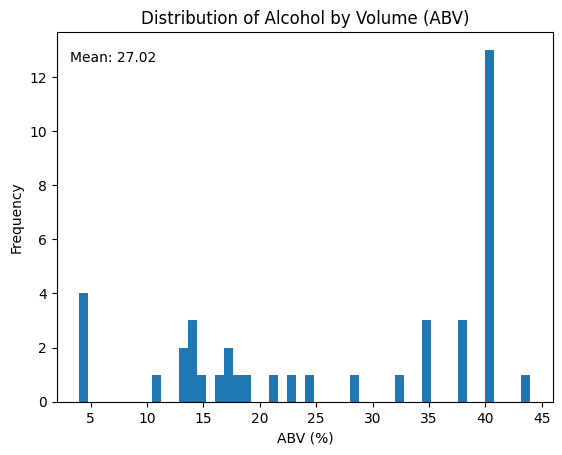

In [10]:
# plot distribution of alco level for coctails with alco level>0
plt.hist(ingredients_df[ingredients_df["abv"]>0]["abv"], bins=50)
plt.title("Distribution of Alcohol by Volume (ABV)")
plt.xlabel("ABV (%)")
plt.ylabel("Frequency")
m=np.mean(ingredients_df[ingredients_df["abv"]>0]["abv"])
plt.text(0.2, 0.95, f"Mean: {round(m,2)}", transform=plt.gca().transAxes, ha='right', va='top')
plt.show()

In [11]:
#Statistics of distribution
ingredients_df[ingredients_df["abv"]>0]["abv"].describe()

count    41.000000
mean     27.024390
std      13.237235
min       4.000000
25%      15.000000
50%      32.000000
75%      40.000000
max      44.000000
Name: abv, dtype: float64

In [12]:
# replace null values in column 'abv' with random values from normal distribution
null_count = ingredients_df['abv'].isnull().sum()
mean = 40
std_dev = ingredients_df[ingredients_df["abv"]>0]["abv"].describe()['std']
random_values = np.round(np.random.normal(mean, std_dev, null_count))
ingredients_df.loc[ingredients_df['abv'].isnull(), 'abv'] = random_values

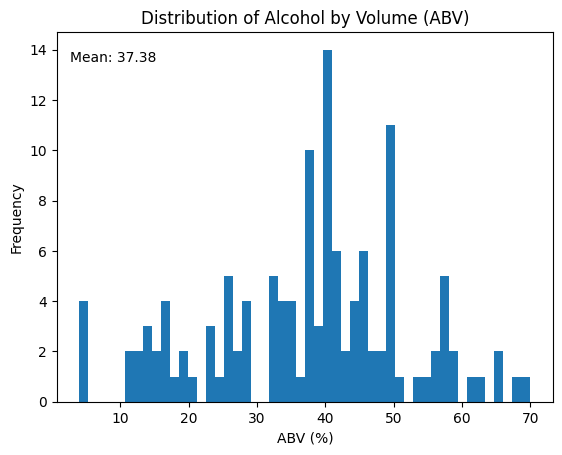

In [13]:
plt.hist(ingredients_df[ingredients_df["abv"]>0]["abv"], bins=50)
plt.title("Distribution of Alcohol by Volume (ABV)")
plt.xlabel("ABV (%)")
plt.ylabel("Frequency")
m=np.mean(ingredients_df[ingredients_df["abv"]>0]["abv"])
plt.text(0.2, 0.95, f"Mean: {round(m,2)}", transform=plt.gca().transAxes, ha='right', va='top')
plt.show()

In [14]:
# this function calculate abv of cocktail
def get_abv(ingredients,measurements):
    alco=float(0)
    if sum(measurements)==0:
        return None
    else:
      for a,b in zip(ingredients,measurements):
          alco+=ingredients_df.loc[ingredients_df['Ingredients'] == a, 'abv'].values[0]*b/sum(measurements)
      return round(alco)

In [48]:
# apply this function to coctails_df
cocktails_df['ABV'] = cocktails_df.apply(lambda row: get_abv(row['Ingredients'], row['Measurements']), axis=1)

In [16]:
#some coctails have broken measurements like 'strMeasure1': '1-2 shot ','strMeasure2': 'Squeeze ','strMeasure3': 'Fill with ', so I will drop some of them
cocktails_df[cocktails_df['ABV'].isnull()]

,Cocktail,Category,Alcoholic,Instruction,Ingredients,Measurements,ABV
16,Aviation,Cocktail,Alcoholic,Add all ingredients into cocktail shaker fille...,"[gin, lemon juice, maraschino liqueur]","[0, 0, 0]",NaN
54,Cuba Libra,Ordinary Drink,Alcoholic,Fill tall glass with ice cubes. Add rum. Rub c...,"[dark rum, lime, coca-cola, ice]","[0, 0, 0, 0]",NaN
83,Dirty Nipple,Shot,Alcoholic,This is a layered shot - the Bailey's must be ...,"[kahlua, sambuca, baileys irish cream]","[0, 0, 0]",NaN
89,Damned if you do,Shot,Alcoholic,Pour into shot glass. Put in mouth. Repeat as ...,"[whiskey, hot damn]","[0, 0]",NaN
114,French Martini,Cocktail,Alcoholic,Pour all ingredients into shaker with ice cube...,"[vodka, raspberry liqueur, pineapple juice]","[0, 0, 0]",NaN
161,Holloween Punch,Punch / Party Drink,Non alcoholic,Take a bunch of grape juice and a bunch of fiz...,"[grape juice, carbonated soft drink, sherbet, ...","[0, 0, 0, 0]",NaN
225,Lone Tree Cooler,Ordinary Drink,Alcoholic,Stir powdered sugar and 2 oz. carbonated water...,"[carbonated water, gin, dry vermouth, powdered...","[0, 0, 0, 0, 0, 0]",NaN
231,Melya,Coffee / Tea,Non alcoholic,"Brew espresso. In a coffee mug, place 1 teaspo...","[espresso, honey, cocoa powder]","[0, 0, 0]",NaN
379,Tequila Surprise,Shot,Alcoholic,Fill shot glass with Tequila. Add drops of Tob...,"[tequila, tabasco sauce]","[0, 0]",NaN
380,Thai Iced Coffee,Coffee / Tea,Non alcoholic,Prepare a pot of coffee at a good European str...,"[coffee, sugar, cream, cardamom]","[0, 0, 0, 0]",NaN


In [17]:
cocktails_df = cocktails_df.dropna(subset=['ABV'])

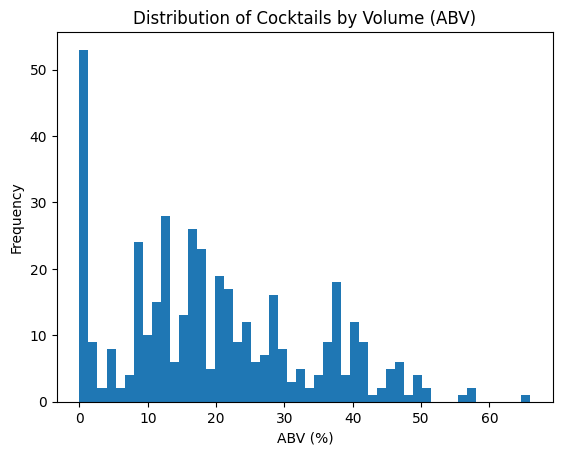

In [18]:
plt.hist(cocktails_df["ABV"], bins=50)
plt.title("Distribution of Cocktails by Volume (ABV)")
plt.xlabel("ABV (%)")
plt.ylabel("Frequency")
plt.show()

In [19]:
#lets translate this df
! pip install translate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from translate import Translator

# Create a translator object
translator = Translator(to_lang="ru")

# Define a function to apply to each string in the Instruction column
def translate_text(text):
    return translator.translate(text)

# Apply the function to the Instruction column
cocktails_df['Instruction'] = cocktails_df['Instruction'].apply(translate_text)

In [25]:
# Initialize list to store user input ingredients
user_ingredients = []

# Get user input for ingredients
while True:
    ingredient = input("Enter an ingredient (or 'end' to finish): ")
    if ingredient == "end":
        break
    elif ingredient not in ingredients_df['Ingredients'].values:
        print("There is no such an ingredient")
    else:
        user_ingredients.append(ingredient)

# Filter cocktails that can be made from user input ingredients
matching_cocktails = cocktails_df[cocktails_df['Ingredients'].apply(lambda x: all(i in user_ingredients for i in x))]

# Print matching cocktails or "no cocktails" if none found
if len(matching_cocktails) > 0:
    print("Cocktails you can make:",', '.join(list(matching_cocktails['Cocktail'])))
    while True:
        s=input("Enter name of coctail you want to make (or 'end' to finish):")
        if s == "end":
            break
        s_rows = matching_cocktails[matching_cocktails['Cocktail'] == s.lower()]
        print('You will need this ingredients:',', '.join([f'{i[1]} of {i[0]}' for i in zip(s_rows.iloc[0]['Ingredients'],s_rows.iloc[0]['Measurements'])]))
        print('Here is instruction: ',s_rows.iloc[0]['Instruction'])
else:
    print("No cocktails found")

Enter an ingredient (or 'end' to finish): 151 proof rum
Enter an ingredient (or 'end' to finish): wild turkey
Enter an ingredient (or 'end' to finish): grenadine
Enter an ingredient (or 'end' to finish): vodka
Enter an ingredient (or 'end' to finish): ice
Enter an ingredient (or 'end' to finish): lime
Enter an ingredient (or 'end' to finish): end
Cocktails you can make: acid
Enter name of coctail you want to make (or 'end' to finish):Acid
You will need this ingredients: 1.0 of 151 proof rum, 1.0 of wild turkey
Here is instruction:  Poor in the 151 first followed by the 101 served with a Coke or Dr Pepper chaser.
Enter name of coctail you want to make (or 'end' to finish):end


In [27]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


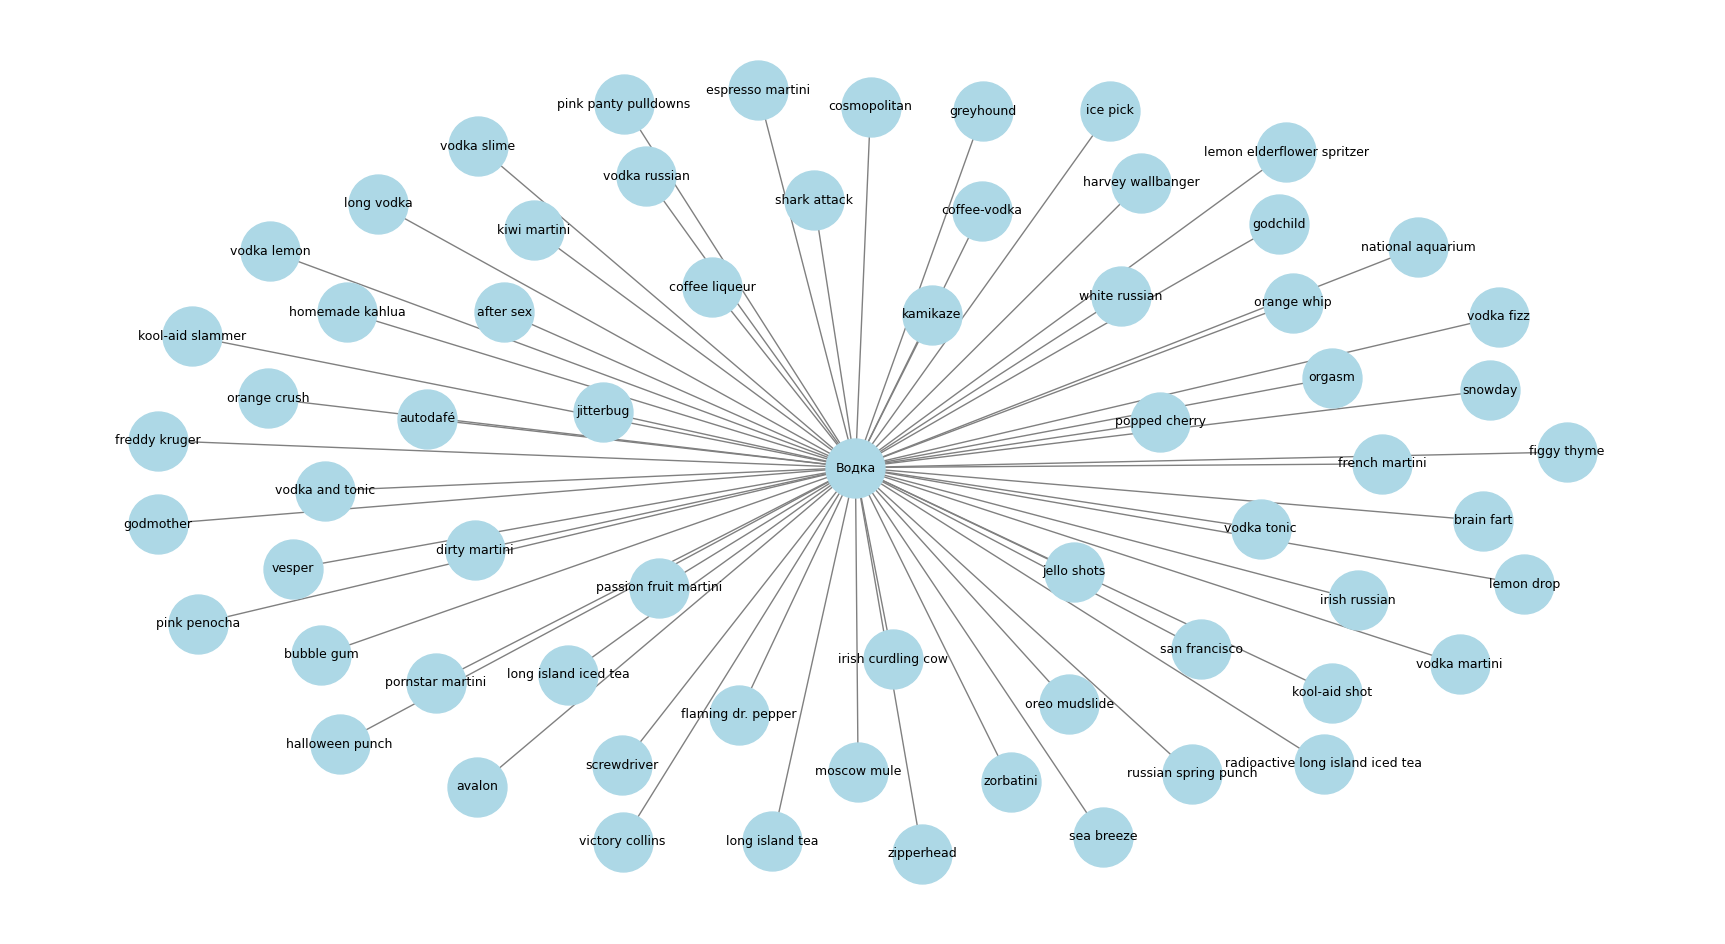

In [28]:
# Vodka is the king of all alcohol
import networkx as nx
# Define list of cocktails that contains vodka
cocktails = list(cocktails_df[cocktails_df['Ingredients'].apply(lambda x: 'vodka'in x)]['Cocktail'])

# Create empty graph
G = nx.Graph()
G.add_node('Водка')
# Add nodes to graph with labels from cocktails list
for cocktail in cocktails:
    G.add_node(cocktail)

# Add edges to connect all nodes to "vodka" node
for cocktail in cocktails:
    G.add_edge('Водка', cocktail)

# Draw graph with labels
pos = nx.spring_layout(G, scale=2)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1800)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')
plt.axis('off')
plt.gcf().set_size_inches(22, 12)
plt.show()

# Интересное
В этой секции я исследую датасет https://www.kaggle.com/datasets/pralabhpoudel/alcohol-consumption-by-country/code

Он показывает зависимость между потреблением алкоголя и ВВП на душу населения
Задействованные методы:


*   Работа с API
*   Pandas
*   SQLite
*   Plotly.express

In [29]:
!pip install kaggle # Install Kaggle API client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import json
token = {"username":"s1nuss","key":"f4716724e8384031620f14342bddf058"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [40]:
!chmod 600 /root/.kaggle/kaggle.json

In [41]:
!kaggle datasets download -d pralabhpoudel/alcohol-consumption-by-country

  0% 0.00/464k [00:00<?, ?B/s]
100% 464k/464k [00:00<00:00, 146MB/s]


In [42]:
# unzip file
!unzip /content/alcohol-consumption-by-country.zip -d /content/data

Archive:  /content/alcohol-consumption-by-country.zip
  inflating: /content/data/alcohol-consumption-vs-gdp-per-capita.csv  


In [44]:
import sqlite3

# Read the CSV file into a Pandas dataframe
df = pd.read_csv('/content/data/alcohol-consumption-vs-gdp-per-capita.csv')

# Connect to the database
conn = sqlite3.connect('database.db')

# Write the dataframe to an SQLite table
df.to_sql('alcohol_consumption', conn, if_exists='replace', index=False)

57084

In [45]:
# Create a cursor object
cur = conn.cursor()

# Execute the query and fetch the results
cur.execute("SELECT * FROM alcohol_consumption")
results = cur.fetchall()

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['country_nm', 'country_cd', 'year', 'total_alco', 'gdp_pc','popul','continent'])


# Write DataFrame to database
df.to_sql('alcohol_consumption', conn, if_exists='replace', index=False)

# Close the cursor
cur.close()

In [46]:
# Group by country_nm and calculate mean of total_alco
mean_alco=pd.read_sql('SELECT country_nm,avg(total_alco)as alco, avg(gdp_pc) as gdp  FROM alcohol_consumption WHERE total_alco is not null and country_cd is not null group by 1', conn)

In [47]:
# Create interactive scatter plot showing dependence between gdp per capita and average alcohol consumption
import plotly.express as px

# Create a scatter plot with Plotly Express
fig = px.scatter(mean_alco, x="gdp", y="alco", hover_name="country_nm")

# Update the layout of the plot
fig.update_layout(
    title="GDP vs Alcohol Consumption",
    xaxis_title="GDP per capita",
    yaxis_title="Alcohol consumption (liters per capita)"
)

# Show the plot
fig.show()